# Quick IRF check

This is a quick IRF check for https://forge.in2p3.fr/issues/16702

See if it's possible to read the CTA IRFs with the Gammapy classes and make some plots.

## Issues

This is very much work in progress. The following issues are clearly visible:
* possible shift by one bin or half a bin where ENERGY or OFFSET nodes are placed. Evaluation at < 1 deg offset not possible.
* matplotlib plotting issue with extent for imshow is visible in several plots (EDISP and PSF). See https://github.com/gammapy/gammapy/issues/823

## TODO

* extend notebook to illustrate all IRFs across parameter space.
* implement some checks (e.g. on-axis and off-axis responses should be consistent)

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import astropy.units as u
from gammapy.scripts import CTAPerf, CTAIrf

## IRFs from Gammapy ROOT -> FITS converter

These are the IRFs obtained from the Gammapy ROOT -> FITS converter

In [6]:
filename = 'CTA-Performance-South-50h_20170119.fits.gz'
cta = CTAPerf.read(filename)

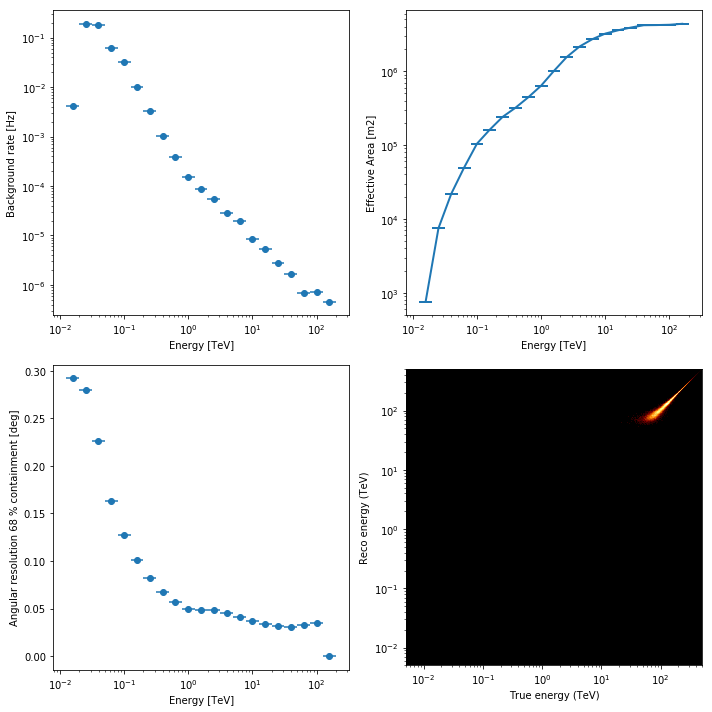

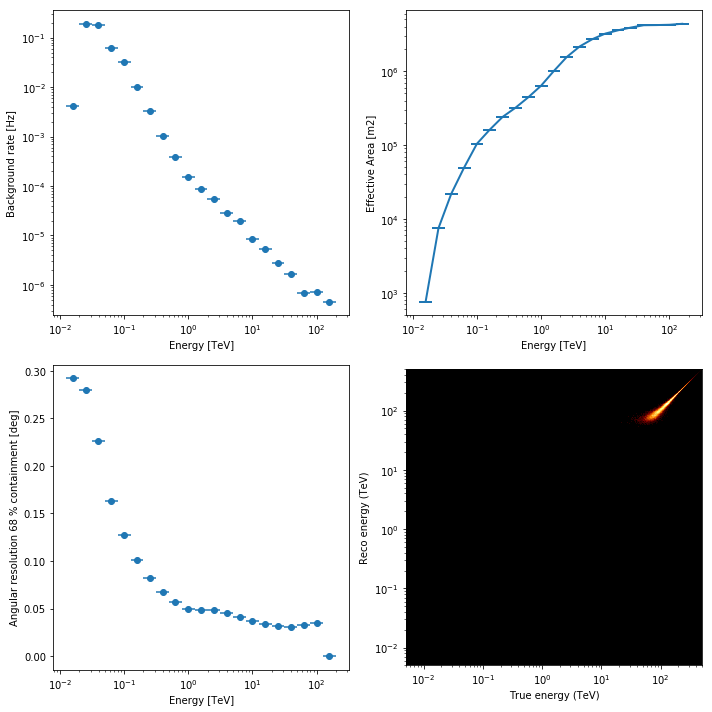

In [7]:
cta.peek()

In [4]:
print(cta.aeff)

EffectiveAreaTable summary info
energy         : size =    22, min =  0.013 TeV, max = 199.526 TeV
Data           : size =    21, min = 764.462 m2, max = 4374099.500 m2



## IRFs from ctools ROOT -> FITS converter

These are the IRFs obtained from the ctools ROOT -> FITS converter

In [8]:
# filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/South_50h/irf_file.fits.gz'
filename = 'caldb/data/cta/prod3b/bcf/South_TS_50h/irf_file.fits'
irf = CTAIrf.read(filename)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/deil/Library/Python/3.5/lib/python/site-packages/astropy/units/quantity.py:960: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:1404: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


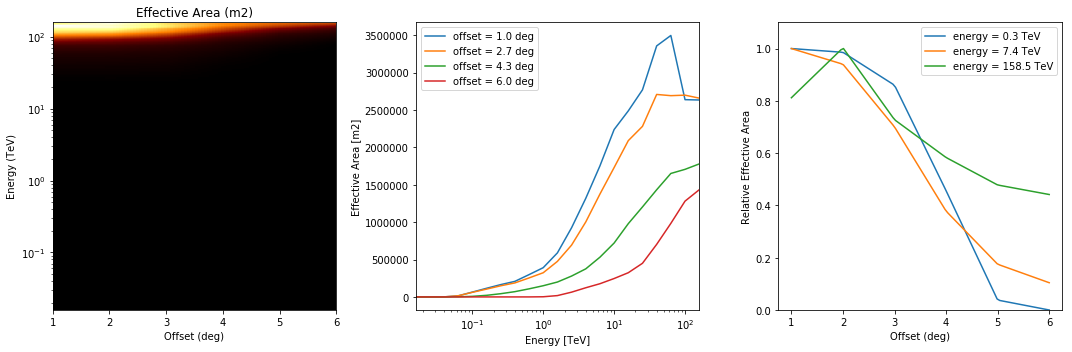

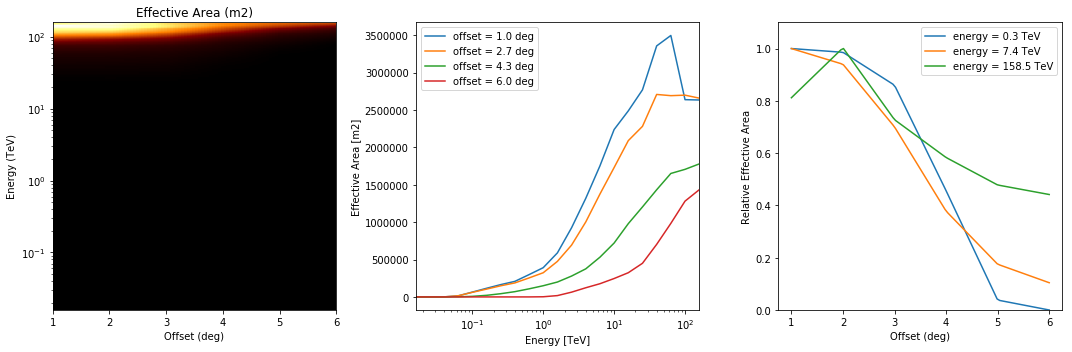

In [9]:
irf.aeff.peek()

/Users/deil/Library/Python/3.5/lib/python/site-packages/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:1404: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:1106: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0


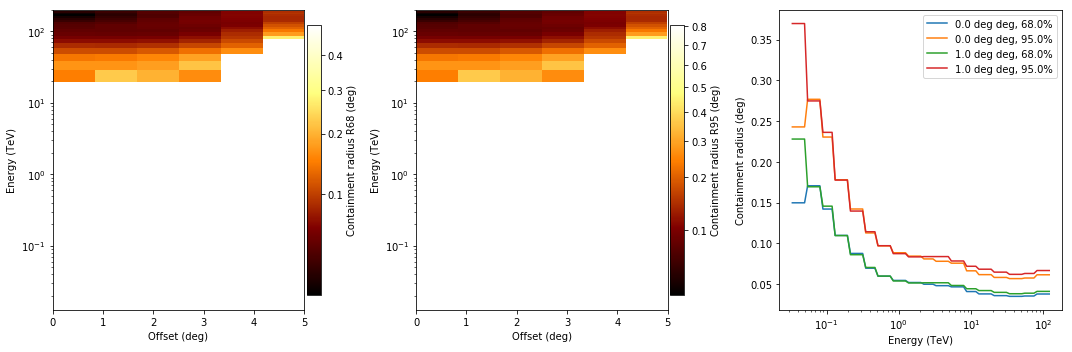

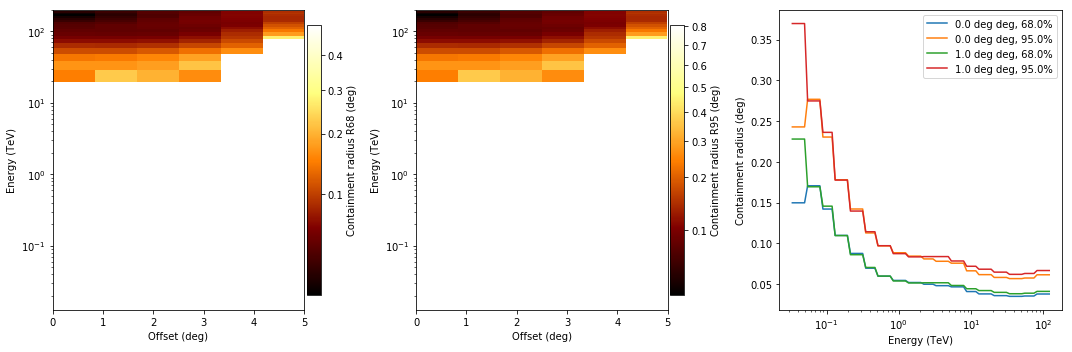

In [10]:
irf.psf.peek()

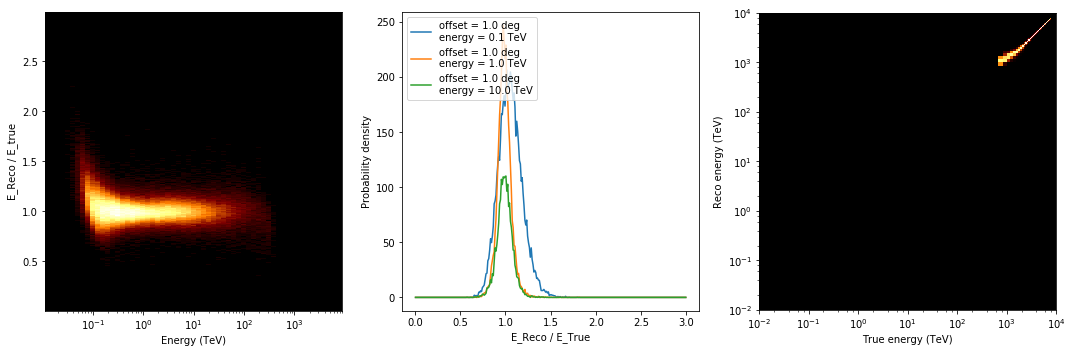

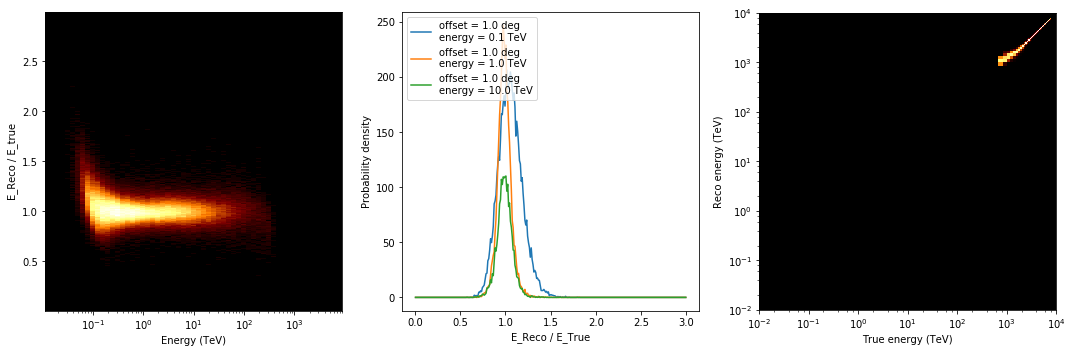

In [11]:
irf.edisp.peek()

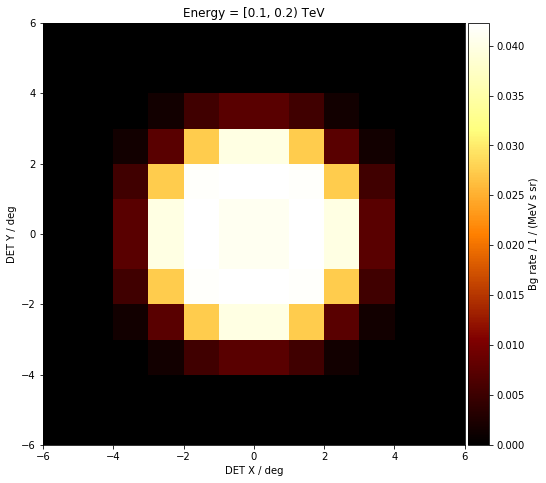

In [12]:
irf.bkg.plot_image(energy='0.1 TeV')

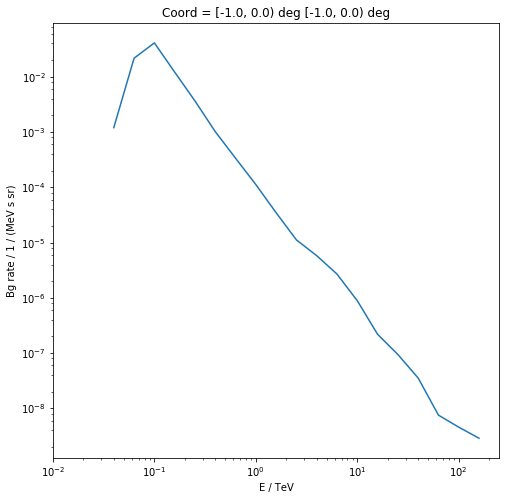

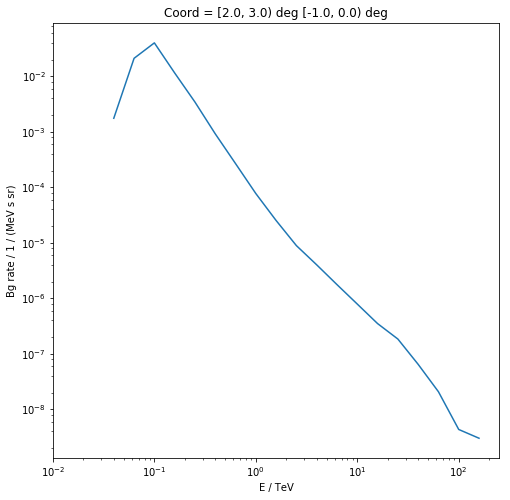

In [13]:
coord = [0, 0] * u.deg
irf.bkg.plot_spectrum(coord=coord)
coord = [3, 0] * u.deg
irf.bkg.plot_spectrum(coord=coord)

## Comparison of IRFs

Here's some quick checks on the IRFs.

(for the moment only for AEFF)

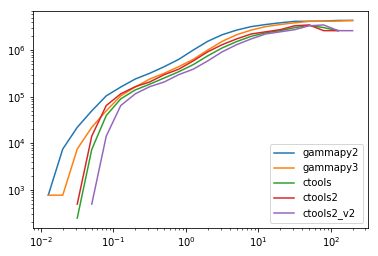

In [68]:
energy = cta.aeff.energy.data

# Evaluating the CTA response at offset < 1 deg currently doesn't work (returns NaNs)
# We need to fix the file or interpolator!
offset = 1.0 * u.deg
aeff_gammapy = cta.aeff.evaluate(energy)
# It looks like evaluate here doesn't give an array with the same length as the input `energy`!?
# As a temp fix, 
aeff_gammapy2 = u.Quantity(list(aeff_gammapy) + [aeff_gammapy[-1]], unit=aeff_gammapy.unit)
aeff_gammapy3 = u.Quantity([aeff_gammapy[0]] + list(aeff_gammapy), unit=aeff_gammapy.unit)
#

aeff_ctools = irf.aeff.evaluate(method='linear', energy=energy, offset=offset)

energy_ctools2 = irf.aeff.energy.data
aeff_ctools2 = irf.aeff.data[:, 0]
# print(energy.shape, aeff_gammapy.shape, aeff_ctools.shape)
# print(aeff_ctools)

fig, ax = plt.subplots()
plt.plot(energy, aeff_gammapy2, label='gammapy2')
plt.plot(energy, aeff_gammapy3, label='gammapy3')
plt.plot(energy, aeff_ctools, label='ctools')
plt.plot(energy_ctools2[:-1], aeff_ctools2, label='ctools2')
plt.plot(energy_ctools2[1:], aeff_ctools2, label='ctools2_v2')
plt.loglog()
plt.legend()

# All the curves are a little different and shifted.
# At the moment I'm 

In [61]:
irf.aeff.data[:, 0]

<Quantity [  0.00000000e+00,  0.00000000e+00,  4.91075195e+02,
             1.42047402e+04,  6.46242656e+04,  1.15426688e+05,
             1.64633844e+05,  2.08020031e+05,  2.98382188e+05,
             3.91273469e+05,  5.89139125e+05,  9.25566250e+05,
             1.31882875e+06,  1.75329488e+06,  2.23943275e+06,
             2.48910750e+06,  2.77066400e+06,  3.35820650e+06,
             3.49791225e+06,  2.63910575e+06,  2.63477725e+06] m2>

In [73]:
# The problem with offset is that we have
print(irf.aeff.offset.data)
# but the FITS file has correct:
# THETA_LO = [0, ..., 5]
# THETA_HI = [1, ..., 6]
# Nodes should be set at [0.5, ..., 5.5]
# and extrapolation should work, i.e. evaluation at 0
# Probably what's needed is to change the class over to NDDataArray?

[ 1.  2.  3.  4.  5.  6.] deg
